In [0]:
%matplotlib inline 
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import warnings
import tensorflow as tf
import random
import scipy
import cv2
from tensorflow.keras.utils import Sequence, to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, MaxPool3D, Dropout, \
        Flatten, Conv3DTranspose, UpSampling3D, Reshape, Input, concatenate
from tensorflow.keras.regularizers import l1_l2
from google.colab import drive
import time

In [2]:
warnings.filterwarnings('ignore')
print('Tensorflow version:', tf.__version__)
print(tf.test.gpu_device_name())
print(tf.python.client.device_lib.list_local_devices())

Tensorflow version: 2.2.0
/device:GPU:0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13744294490029903969
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11597981674763343994
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15418350984148670674
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11066894933054085453
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


In [0]:
!cat /proc/meminfo

MemTotal:       26751700 kB
MemFree:        22505428 kB
MemAvailable:   25121716 kB
Buffers:           75228 kB
Cached:          2734600 kB
SwapCached:            0 kB
Active:          1221348 kB
Inactive:        2534288 kB
Active(anon):     875244 kB
Inactive(anon):     8524 kB
Active(file):     346104 kB
Inactive(file):  2525764 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               592 kB
Writeback:             0 kB
AnonPages:        945824 kB
Mapped:           682112 kB
Shmem:              9140 kB
Slab:             197464 kB
SReclaimable:     134624 kB
SUnreclaim:        62840 kB
KernelStack:        4376 kB
PageTables:         9068 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:    13375848 kB
Committed_AS:    3428152 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
Percpu:             1824 kB
AnonHugePages:   

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#### Create Train/Validation/Test Subsets

In [0]:
%cd /content/drive/My Drive/AD_MRI

# Load list of records
with open('AD_MRI_Master', 'rb') as f:
    master_list = pickle.load(f)
    
master_sheet = pd.DataFrame.from_dict(master_list, orient='index')
display(master_sheet.head())
print(master_sheet.shape)
print()

###
# Split: 80% train, 10% test; of train: 10% validation
train_list, test_list, train_label, test_label = \
        train_test_split(master_sheet.subject.values, 
                         master_sheet.diagnosis.values, 
                         random_state = 1337, 
                         test_size=0.1)
        
train_list, val_list, train_label, val_label = \
        train_test_split(train_list, 
                         train_label, 
                         random_state = 0, 
                         test_size=0.1)
###

###
# Split: 80% train, 10% validation, 10% test
# train_list, test_list, train_label, test_label = \
#         train_test_split(master_sheet.subject.values, 
#                          master_sheet.diagnosis.values, 
#                          random_state = 1337, 
#                          test_size=0.2)
        
# test_list, val_list, test_label, val_label = \
#         train_test_split(test_list, 
#                          test_label, 
#                          random_state = 0, 
#                          test_size=0.5)
###

# Check for ratios of AD to NC to be consistent among sets
AD_count = 0
for lab in train_label:
    if lab == 'AD':
        AD_count +=1
print('train_ratio AD: ', round(AD_count/len(train_label), 3))

AD_count = 0
for lab in val_label:
    if lab == 'AD':
        AD_count +=1
print('val_ratio AD: ', round(AD_count/len(val_label), 3))

AD_count = 0
for lab in test_label:
    if lab == 'AD':
        AD_count +=1
print('test_ratio AD: ', round(AD_count/len(test_label), 3))

print('\nNumber of records\ntrain:', len(train_list), 
      '\nvalidation:', len(val_list), '\ntest:', len(test_list))


/content/drive/.shortcut-targets-by-id/1oU0ruELKPJf457X2y4uyGIpFkyyxaQyv/AD_MRI


,subject,age,diagnosis,scan_ID
OAS30001,OAS30001,65.0,CN,OAS30001_MR_d0129
OAS30002,OAS30002,68.0,CN,OAS30002_MR_d0371
OAS30003,OAS30003,60.0,CN,OAS30003_MR_d0558
OAS30004,OAS30004,58.0,CN,OAS30004_MR_d1101
OAS30005,OAS30005,48.0,CN,OAS30005_MR_d0143


(980, 4)

train_ratio AD:  0.367
val_ratio AD:  0.371
test_ratio AD:  0.367

Number of records
train: 793 
validation: 89 
test: 98


### Create Generator

In [0]:
processed_dir = '/content/drive/My Drive/AD_MRI/PROCESSED/'

# Convert categorical labels
# CN: 0, AD: 1
def labels_to_categorical(labels):
    le = LabelEncoder()
    le.fit(["CN", "AD"])
    num_labels = to_categorical(le.transform(labels), num_classes=2)
    return num_labels


# Custom data generator
class MyDataGenerator(Sequence):
    """Generates data for Keras Sequence based data generator. 
    Suitable for building data generator for training and prediction.
    """
    def __init__(self, list_IDs, processed_dir, augment=False, 
                 to_fit=True, batch_size=32, dim=(120, 160, 120, 1),
                 n_classes=2, shuffle=True, ventricles_only=True, 
                 slice_start=50, slice_end=66, sample_weight=None):
        """Initialization
        :param list_IDs: list of all 'label' PATHS
        :param processed_dir: path to directory of processed images
        :param augment
        :param to_fit: True to return X and y, False to return X only
        :param batch_size: batch size at each iteration
        :param dim: tuple indicating image dimension
        :param n_classes: number of output masks
        :param shuffle: True to shuffle label indexes after every epoch
        :param ventricles_only: reduce dimensions to relevant slice
        """
        self.list_IDs = list_IDs
        self.processed_dir = processed_dir
        self.augment = augment
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.dim = dim
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.ventricles_only = ventricles_only
        self.on_epoch_end()
        self.slice_start = slice_start
        self.slice_end = slice_end
        if self.ventricles_only == False:
            self.slice_size = 120
        else:
            self.slice_size = slice_end - slice_start
        self.sample_weight = sample_weight
        # sample_weight needs to be provided if to_fit=True


    def __len__(self):
        """Denotes the number of batches per epoch
        :return: number of batches per epoch
        """
        return int(np.floor(len(self.list_IDs) / self.batch_size))


    def __getitem__(self, index):
        """Generate one batch of data
        :param index: index of the batch
        :return: X and y when fitting. X only when predicting
        """
        # Generate indexes of the batch
        indexes = self.indexes[index 
                               * self.batch_size:(index + 1) 
                               * self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        
        # Generate data
        X, y = self._load_data(list_IDs_temp)
        X = np.float32(X)
        if self.ventricles_only == True:
          X = X[:, :, :, self.slice_start:self.slice_end, :]
        if self.to_fit:
            y = {'ICAE_classifier': y, 'ICAE_decoder': X}
            return X, y, self.sample_weight
        else:
            return X


    def on_epoch_end(self):
        """Updates indexes after each epoch
        """
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


    def _load_data(self, list_IDs_temp):
        """Generates data containing batch_size images
        :param list_IDs_temp: list of label ids to load
        :return: batch of images
        """
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        y = np.empty((self.batch_size, self.n_classes), dtype=int)
        
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            
            # start X
            with open(self.processed_dir+ID+'_data','rb') as f:
                data = pickle.load(f)
                
            # third dimension = 120, error using self.slice_size for value 16
            x_reshape= np.reshape(data['image'], (120, 160, 120, 1))
            if self.augment == True:
                x_reshape = scipy.ndimage.rotate(x_reshape, 
                                axes=random.choice([(0, 1), (0, 2), (1, 2)]), 
                                angle=random.choice([360-15, 15]), 
                                reshape=False)
            X[i,] = x_reshape
            
            #start y
            y[i,] = labels_to_categorical([data['diagnosis']])

        return X, y

    

In [0]:
# Class imbalance handling
balancing_weights = class_weight.compute_sample_weight('balanced', train_label)
len(balancing_weights)

793

In [0]:
mdg = MyDataGenerator(test_list, processed_dir, to_fit=True, augment=False, 
                      sample_weight=balancing_weights)

X, pred, weights = mdg.__getitem__(0)

In [0]:
X.shape

(32, 120, 160, 16, 1)

In [0]:
len(weights)

793

In [0]:
list(pred) # [y, X]

['ICAE_classifier', 'ICAE_decoder']

#### Building CAE Encoder

In [0]:
dropout = 0.2

input_img = Input(shape=(120, 160, 16, 1), name='Input')
print('\ninput shape:', input_img.shape)

x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
           name='Convolution_1')(input_img)
x = MaxPool3D((2, 2, 2), name='MaxPooling_1')(x)
x = Dropout(dropout, name='DropOut_1')(x)

x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
           name='Convolution_2')(x)
x = MaxPool3D((2, 2, 2), name='MaxPooling_2')(x)
x = Dropout(dropout, name='DropOut_2')(x)

x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
           name='Convolution_3')(x)
x = MaxPool3D((2, 2, 2), name='MaxPooling_3')(x)
x = Dropout(dropout, name='DropOut_3')(x)

encoded = x
encoded_shape = K.int_shape(encoded)
print('output shape:', encoded_shape, '\n')

CAE_encoder = Model(input_img, encoded, name='CAE_encoder')
CAE_encoder.summary()



input shape: (None, 120, 160, 16, 1)
output shape: (None, 15, 20, 2, 10) 

Model: "CAE_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 16, 1)] 0         
_________________________________________________________________
Convolution_1 (Conv3D)       (None, 120, 160, 16, 10)  280       
_________________________________________________________________
MaxPooling_1 (MaxPooling3D)  (None, 60, 80, 8, 10)     0         
_________________________________________________________________
DropOut_1 (Dropout)          (None, 60, 80, 8, 10)     0         
_________________________________________________________________
Convolution_2 (Conv3D)       (None, 60, 80, 8, 10)     2710      
_________________________________________________________________
MaxPooling_2 (MaxPooling3D)  (None, 30, 40, 4, 10)     0         
_____________________________________________

#### Building CAE Decoder

In [0]:
encoded_shape

(None, 15, 20, 2, 10)

In [0]:
encoded_input = Input(shape=(encoded_shape[1],encoded_shape[2], 
                             encoded_shape[3], encoded_shape[4],), 
                      name='Encoded')

print('\ninput shape:', encoded_input.shape)
x = encoded_input

x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                    name='Convolution_3')(x)
x = UpSampling3D((2, 2, 2), name='UpSampling_3')(x)
x = Dropout(dropout, name='DropOut_3')(x)

x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                    name='Convolution_2')(x)
x = UpSampling3D((2, 2, 2), name='UpSampling_2')(x)
x = Dropout(dropout, name='DropOut_2')(x)

x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                    name='Convolution_1')(x)
x = UpSampling3D((2, 2, 2), name='UpSampling_1')(x)
x = Dropout(dropout, name='DropOut_1')(x)

decoded = Conv3DTranspose(1, (3, 3, 3), activation='sigmoid', padding='same', 
                          name='Output')(x)

print('output shape:', K.int_shape(decoded), '\n')

CAE_decoder = Model(encoded_input, decoded, name='CAE_decoder')
CAE_decoder.summary()


input shape: (None, 15, 20, 2, 10)
output shape: (None, 120, 160, 16, 1) 

Model: "CAE_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoded (InputLayer)         [(None, 15, 20, 2, 10)]   0         
_________________________________________________________________
Convolution_3 (Conv3DTranspo (None, 15, 20, 2, 10)     2710      
_________________________________________________________________
UpSampling_3 (UpSampling3D)  (None, 30, 40, 4, 10)     0         
_________________________________________________________________
DropOut_3 (Dropout)          (None, 30, 40, 4, 10)     0         
_________________________________________________________________
Convolution_2 (Conv3DTranspo (None, 30, 40, 4, 10)     2710      
_________________________________________________________________
UpSampling_2 (UpSampling3D)  (None, 60, 80, 8, 10)     0         
_____________________________________________

#### Building CAE Autoencoder

In [0]:
CAE_autoencoder = Model(input_img, CAE_decoder(CAE_encoder(input_img)), 
                        name='CAE_autoencoder')
CAE_autoencoder.summary()

Model: "CAE_autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 120, 160, 16, 1)] 0         
_________________________________________________________________
CAE_encoder (Model)          (None, 15, 20, 2, 10)     5700      
_________________________________________________________________
CAE_decoder (Model)          (None, 120, 160, 16, 1)   8401      
Total params: 14,101
Trainable params: 14,101
Non-trainable params: 0
_________________________________________________________________


In [0]:
CAE_autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

### ICAE Inception Model

#### Building ICAE Encoder

In [0]:
def inception_module(input, filter_operation):
    """
    filter_operation is a list of inception operations for:
        1x1x1 kernel, 
        1x1x1 then 3x3x3 kernels, 
        1x1x1 then 3x3x3 then 3x3x3 kernels, 
        and 3x3x3 maxpooling then 1x1x1 kernels, 
            respectively.
    """
    
    # According to Nature paper (Oh et. al.), l1 and l2 values of 10e-4 
    # performed the best from experimentation with 0.01, 0.001, 0.0001, 0.00001 
    # values.
    l1_value = 10e-4 #10e-4
    l2_value = 10e-4 #10e-4

    # Branch A
    branch_1x1x1 = Conv3D(filter_operation[0], kernel_size=(1, 1, 1), 
                          activation='relu', padding='same', 
                          kernel_regularizer=l1_l2(l1_value, l2_value), 
                          name='Branch_A_1x1x1')(input)

    # Branch B
    branch_3x3x3_initial = Conv3D(filter_operation[1], kernel_size=(1, 1, 1), 
                                  activation='relu', padding='same', 
                                  kernel_regularizer=l1_l2(l1_value, l2_value), 
                                  name='Branch_B_1x1x1')(input)
    branch_3x3x3 = Conv3D(filter_operation[1], kernel_size=(3, 3, 3), 
                          activation='relu', padding='same', 
                          kernel_regularizer=l1_l2(l1_value, l2_value), 
                          name='Branch_B_3x3x3')(branch_3x3x3_initial)

    # Branch C
    branch_double_3x3x3_initial = Conv3D(filter_operation[2], 
                                         kernel_size=(1, 1, 1), 
                                         activation='relu', padding='same', 
                                         kernel_regularizer=l1_l2(l1_value, 
                                                                  l2_value), 
                                         name='Branch_C_1x1x1')(input)
    branch_double_3x3x3_middle = Conv3D(filter_operation[2], 
                                        kernel_size=(3, 3, 3), 
                                        activation='relu', padding='same', 
                                        kernel_regularizer=l1_l2(l1_value, 
                                                                 l2_value), 
                                        name='Branch_C_1st_3x3x3')\
                                        (branch_double_3x3x3_initial)
    branch_double_3x3x3 = Conv3D(filter_operation[2], kernel_size=(3, 3, 3), 
                                 activation='relu', padding='same', 
                                 kernel_regularizer=l1_l2(l1_value, l2_value), 
                                 name='Branch_C_2nd_3x3x3')\
                                 (branch_double_3x3x3_middle)

    # Branch D
    branch_maxpool_3x3x3_initial = MaxPool3D(pool_size=(3, 3, 3), 
                                             strides=(1, 1, 1), padding='same', 
                                             name='Branch_D_3x3x3_maxpool')\
                                             (input)
    branch_maxpool_3x3x3 = Conv3D(filter_operation[3], kernel_size=(1, 1, 1), 
                                  activation='relu', padding='same', 
                                  kernel_regularizer=l1_l2(l1_value, l2_value), 
                                  name='Branch_D_1x1x1')\
                                  (branch_maxpool_3x3x3_initial)
    
    # Merge branches
    modules = [branch_1x1x1, branch_3x3x3, branch_double_3x3x3, 
               branch_maxpool_3x3x3]
    merged_module = concatenate(modules, name='Inception_Merged')
    
    return merged_module
    


In [0]:
filter_operations = [10, 10, 10, 10]
dropout = 0.8

input_img = Input(shape= (120, 160, 16, 1), name='Input')
print('\ninput shape:', input_img.shape)

x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
           name='Convolution_1')(input_img)
x = MaxPool3D((2, 2, 2), name='MaxPooling_1')(x)
x = Dropout(dropout, name='DropOut_1')(x)

x = Conv3D(10, (3, 3, 3), activation='relu', padding='same', 
           name='Convolution_2')(x)
x = MaxPool3D((2, 2, 2), name='MaxPooling_2')(x)
x = Dropout(dropout, name='DropOut_2')(x)

x = inception_module(x, filter_operations)
x = MaxPool3D((2, 2, 2), name='Inception_MaxPooling')(x)
x = Dropout(dropout, name='DropOut_3')(x)

encoded = x
encoded_shape = K.int_shape(encoded)
print('output shape:', encoded_shape, '\n')

ICAE_encoder = Model(input_img, encoded, name='ICAE_encoder')
ICAE_encoder.summary(positions=[.35, .64, .71, 1.]) 
# `positions` adjusts print settings to minimize truncation


input shape: (None, 120, 160, 16, 1)
output shape: (None, 15, 20, 2, 40) 

Model: "ICAE_encoder"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                Param  Connected to                 
Input (InputLayer)                [(None, 120, 160, 16, 1)]   0                                   
__________________________________________________________________________________________________
Convolution_1 (Conv3D)            (None, 120, 160, 16, 10)    280    Input[0][0]                  
__________________________________________________________________________________________________
MaxPooling_1 (MaxPooling3D)       (None, 60, 80, 8, 10)       0      Convolution_1[0][0]          
__________________________________________________________________________________________________
DropOut_1 (Dropout)               (None, 60, 80, 8, 10)       0      MaxPooling_1[0][0]           
___________

#### Building ICAE Decoder

In [0]:
encoded_input= Input(shape=(encoded_shape[1], encoded_shape[2], 
                            encoded_shape[3], encoded_shape[4],), 
                     name='Encoded')
print('\ninput shape:', encoded_input.shape)

combined_dim = sum(filter_operations) 
# `filter_operations` and `dropout` taken from ICAE encoder

x = encoded_input

x = inception_module(x, filter_operations)
x = UpSampling3D((2, 2, 2), name='Inception_Upsampling')(x)
x = Dropout(dropout, name='DropOut_3')(x)

x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                    name='Convolution_2')(x)
x = UpSampling3D((2, 2, 2), name='Upsampling_2')(x)
x = Dropout(dropout, name='DropOut_2')(x)

x = Conv3DTranspose(10, (3, 3, 3), activation='relu', padding='same', 
                    name='Convolution_1')(x)
x = UpSampling3D((2, 2, 2), name='Upsampling_1')(x)
x = Dropout(dropout, name='DropOut_1')(x)

decoded = Conv3DTranspose(1, (3, 3, 3), activation='sigmoid', padding='same', 
                          name='Output')(x)

print('output shape:', K.int_shape(decoded), '\n')

ICAE_decoder = Model(encoded_input, decoded, name='ICAE_decoder')
ICAE_decoder.summary(positions=[.35, .64, .71, 1.])



input shape: (None, 15, 20, 2, 40)
output shape: (None, 120, 160, 16, 1) 

Model: "ICAE_decoder"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                Param  Connected to                 
Encoded (InputLayer)              [(None, 15, 20, 2, 40)]     0                                   
__________________________________________________________________________________________________
Branch_C_1x1x1 (Conv3D)           (None, 15, 20, 2, 10)       410    Encoded[0][0]                
__________________________________________________________________________________________________
Branch_B_1x1x1 (Conv3D)           (None, 15, 20, 2, 10)       410    Encoded[0][0]                
__________________________________________________________________________________________________
Branch_C_1st_3x3x3 (Conv3D)       (None, 15, 20, 2, 10)       2710   Branch_C_1x1x1[0][0]         
___________

#### Building ICAE Classifier

In [0]:
# ICAE Classifier

encoded_input = Input(shape=(encoded_shape[1], encoded_shape[2], 
                             encoded_shape[3], encoded_shape[4],), 
                      name='Encoded')

y = encoded_input

y = Conv3D(10, (1, 1, 1), padding='same', name='Linear')(y)
y = Flatten(name='Flatten')(y)
y = Dense(64, activation='selu', name='SELU_1')(y) #32
y = Dense(16, activation='selu', name='SELU_2')(y) #16
y = Dense(2, activation='softmax', name='Prediction')(y)

ICAE_pred = y

ICAE_classifier = Model(encoded_input, ICAE_pred, name='ICAE_classifier')
ICAE_classifier.summary()

Model: "ICAE_classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Encoded (InputLayer)         [(None, 15, 20, 2, 40)]   0         
_________________________________________________________________
Linear (Conv3D)              (None, 15, 20, 2, 10)     410       
_________________________________________________________________
Flatten (Flatten)            (None, 6000)              0         
_________________________________________________________________
SELU_1 (Dense)               (None, 64)                384064    
_________________________________________________________________
SELU_2 (Dense)               (None, 16)                1040      
_________________________________________________________________
Prediction (Dense)           (None, 2)                 34        
Total params: 385,548
Trainable params: 385,548
Non-trainable params: 0
_____________________________________________

####  Building Autoencoder

In [0]:
ICAE_autoencoder = Model(inputs=input_img, 
                         outputs=[ICAE_decoder(ICAE_encoder(input_img)), 
                                  ICAE_classifier(ICAE_encoder(input_img))],
                   name='ICAE_autoencoder')
ICAE_autoencoder.summary(positions=[.35, .64, .71, 1.])

Model: "ICAE_autoencoder"
__________________________________________________________________________________________________
Layer (type)                      Output Shape                Param  Connected to                 
Input (InputLayer)                [(None, 120, 160, 16, 1)]   0                                   
__________________________________________________________________________________________________
ICAE_encoder (Model)              (None, 15, 20, 2, 40)       11560  Input[0][0]                  
                                                                     Input[0][0]                  
__________________________________________________________________________________________________
ICAE_decoder (Model)              (None, 120, 160, 16, 1)     23561  ICAE_encoder[1][0]           
__________________________________________________________________________________________________
ICAE_classifier (Model)           (None, 2)                   385548 ICAE_encoder[2

#### Plot Models

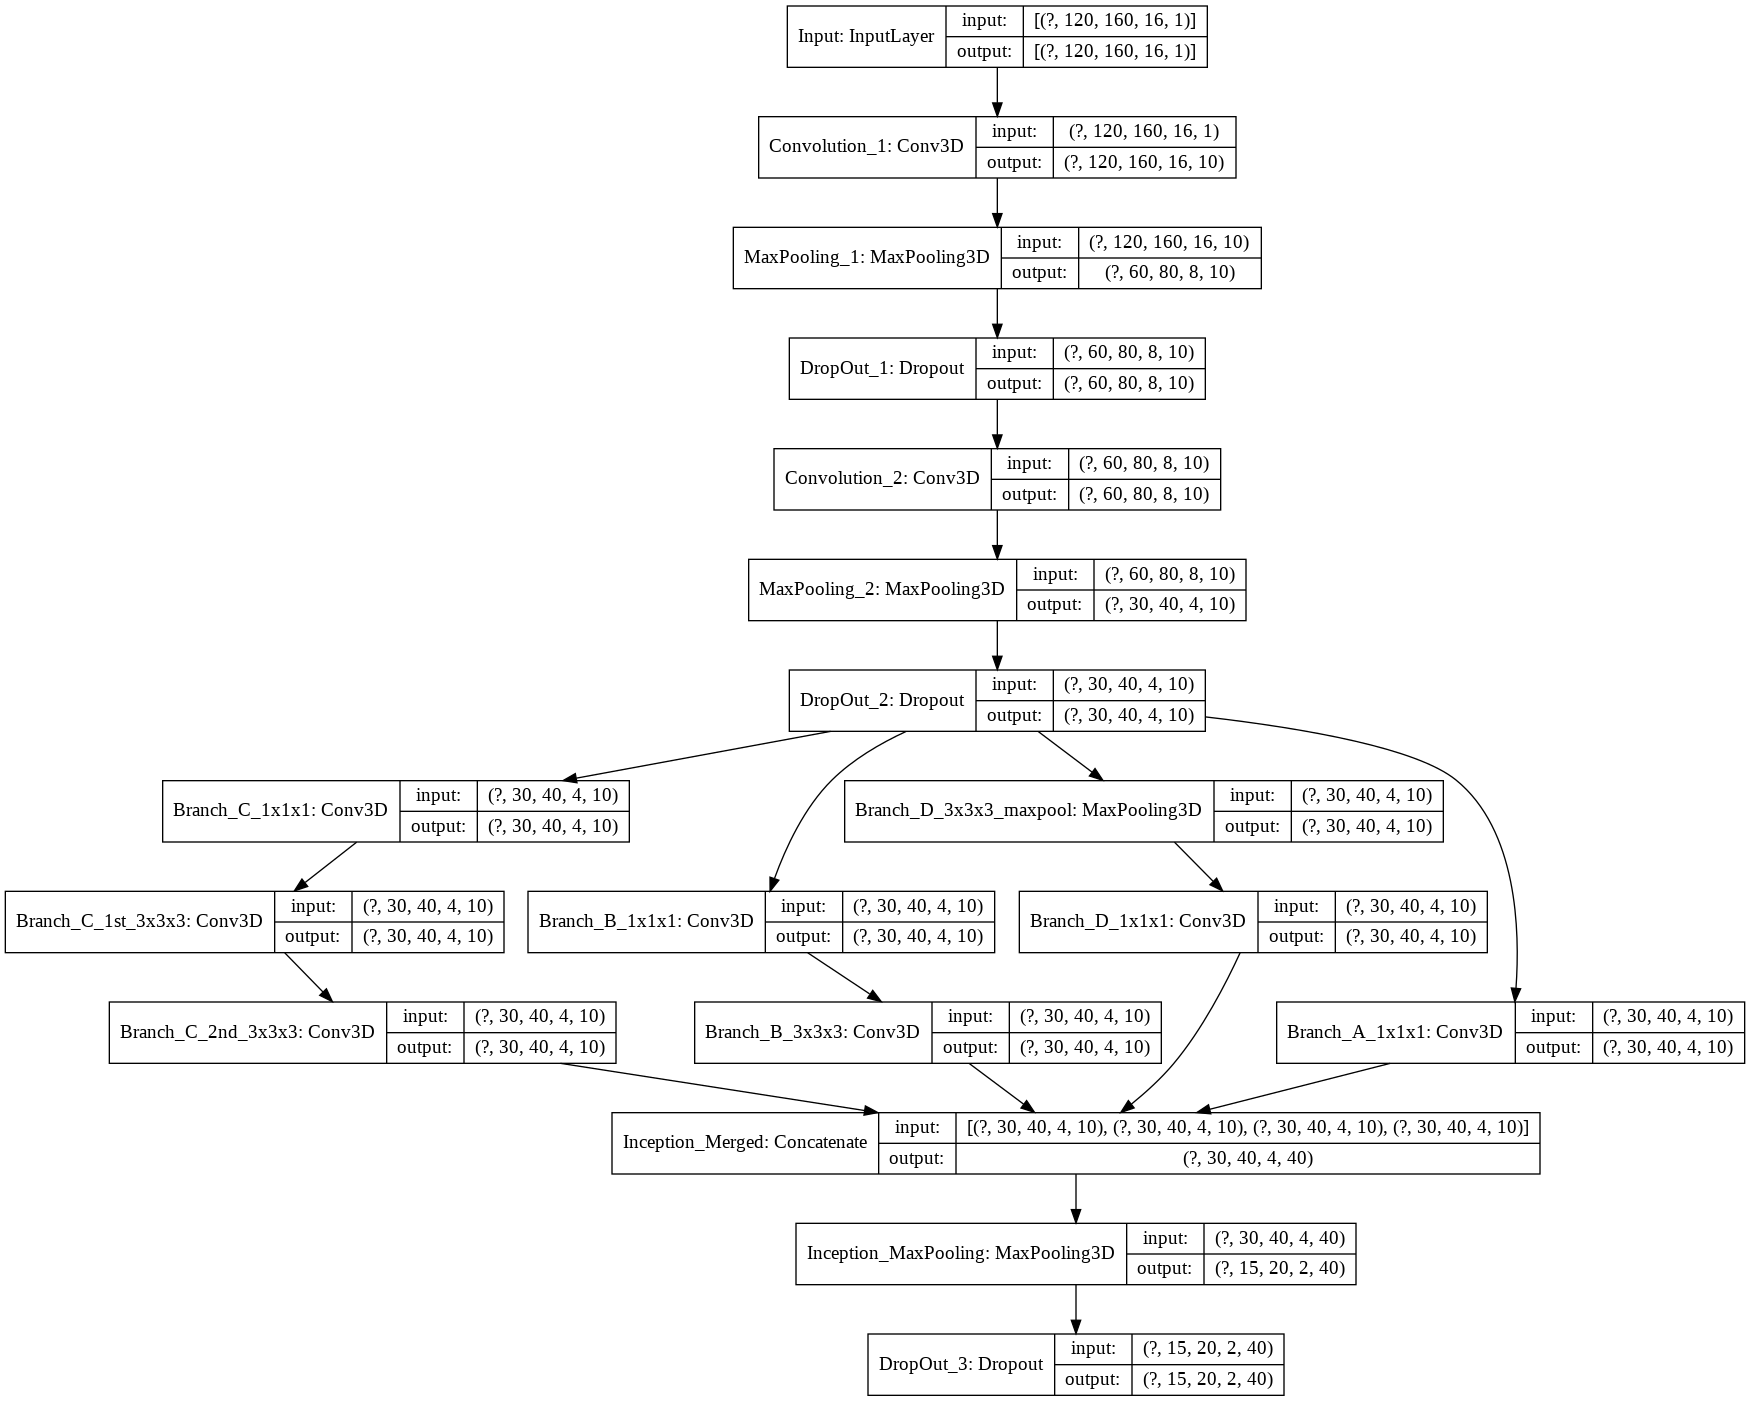

In [0]:
plot_model(ICAE_encoder, to_file='outputs_AC/ICAE_encoder_do80.png', show_shapes=True, show_layer_names=True)

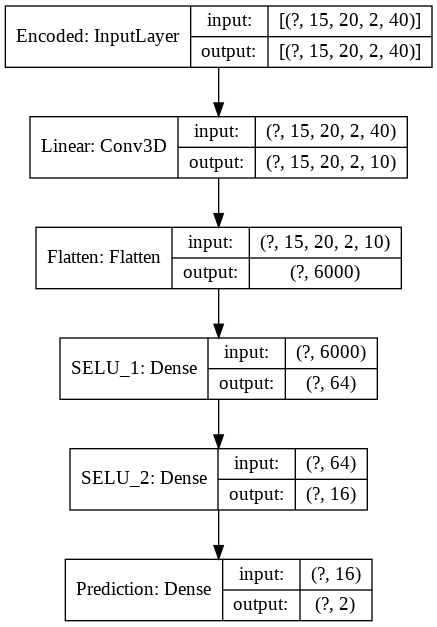

In [0]:
plot_model(ICAE_classifier, to_file='outputs_AC/ICAE_classifier_do80.png', show_shapes=True, show_layer_names=True)

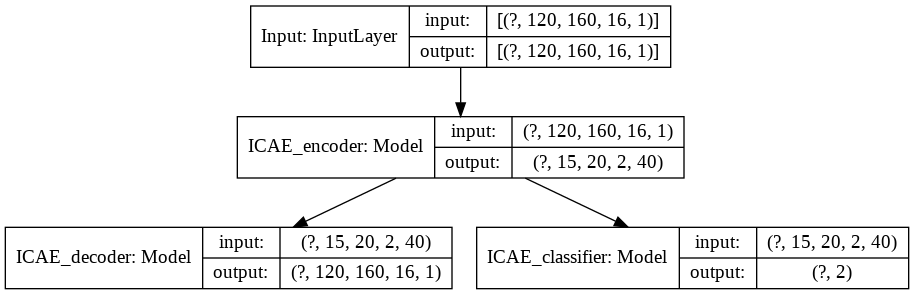

In [0]:
plot_model(ICAE_autoencoder, to_file='outputs_AC/ICAE_autoencoder_do80.png', show_shapes=True, show_layer_names=True)

#### ICAE Training Setup

In [0]:
losses = {'ICAE_decoder':'mse', 'ICAE_classifier':'categorical_crossentropy'}
metrics = {'ICAE_decoder':'mae', 'ICAE_classifier':[\
                            tf.keras.metrics.BinaryAccuracy(name='acc'),
                            tf.keras.metrics.Precision(name='p'), 
                            tf.keras.metrics.Recall(name='r'),
                            tf.keras.metrics.TruePositives(name='tp'), 
                            tf.keras.metrics.FalseNegatives(name='fn')]}
loss_weights = {'ICAE_decoder':0.5, 'ICAE_classifier':0.5}

ICAE_autoencoder.compile(optimizer='sgd', 
                         loss=losses,
                         loss_weights=loss_weights,
                         metrics=metrics)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.ModelCheckpoint(\
        filepath=\
        'outputs_AC/ICAE_experiment_do80_AC_925.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs_AC')] # initialed AC

In [0]:
train_generator = MyDataGenerator(train_list, processed_dir, to_fit=True, 
                                  augment=True, batch_size=32)
val_generator = MyDataGenerator(val_list, processed_dir, to_fit=True, 
                                  augment=False, batch_size=32)

#### Training

In [0]:
start_time = time.time()

history_ICAE = ICAE_autoencoder.fit(train_generator, epochs=25, 
                                    validation_data=val_generator, 
                                    shuffle=True, use_multiprocessing=False, 
                                    callbacks=my_callbacks)

duration = round((time.time() - start_time) / 60, 2)

print('Time taken:', duration, 'minutes')

Epoch 1/25
24/24 [==============================] - 615s 26s/step - loss: 1.9637 - ICAE_decoder_loss: 0.2421 - ICAE_classifier_loss: 0.8984 - ICAE_decoder_mae: 0.3989 - ICAE_classifier_acc: 0.5846 - ICAE_classifier_p: 0.5846 - ICAE_classifier_r: 0.5846 - ICAE_classifier_tp: 449.0000 - ICAE_classifier_fn: 319.0000 - val_loss: 1.7927 - val_ICAE_decoder_loss: 0.1143 - val_ICAE_classifier_loss: 0.6904 - val_ICAE_decoder_mae: 0.2943 - val_ICAE_classifier_acc: 0.6094 - val_ICAE_classifier_p: 0.6094 - val_ICAE_classifier_r: 0.6094 - val_ICAE_classifier_tp: 39.0000 - val_ICAE_classifier_fn: 25.0000
Epoch 2/25
24/24 [==============================] - 377s 16s/step - loss: 1.8003 - ICAE_decoder_loss: 0.1440 - ICAE_classifier_loss: 0.6813 - ICAE_decoder_mae: 0.3062 - ICAE_classifier_acc: 0.6042 - ICAE_classifier_p: 0.6042 - ICAE_classifier_r: 0.6042 - ICAE_classifier_tp: 464.0000 - ICAE_classifier_fn: 304.0000 - val_loss: 1.7844 - val_ICAE_decoder_loss: 0.1141 - val_ICAE_classifier_loss: 0.6853 -

#### Initial Results

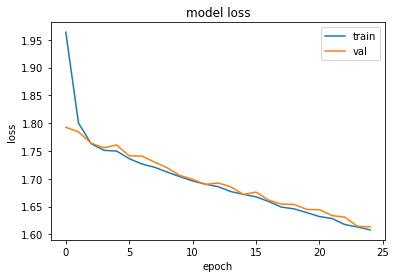

In [0]:
ICAE_autoencoder.save('ICAE_autoencoder_25epochs.h5')
with open('outputs_AC/trainHistoryDict', 'wb') as file_pi:
        pickle.dump(history_ICAE.history, file_pi)
plt.plot(history_ICAE.history['loss'])
plt.plot(history_ICAE.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [0]:
print('Time taken:', round(duration / 60, 2), 'hours')

Time taken: 2.69 hours


In [0]:
test_generator = MyDataGenerator(test_list, processed_dir, batch_size=14, 
                                 augment=False, to_fit=True)

In [0]:
ae_pred = ICAE_autoencoder.predict(test_generator)

In [0]:
np.sum(np.round(ae_pred[1]),axis=0)

array([ 0., 98.], dtype=float32)

In [0]:
test_label.shape

(98,)

In [0]:
ae_pred[1].shape

(98, 2)

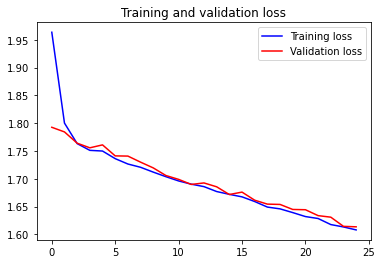

In [0]:
train_loss = history_ICAE.history['loss']
val_loss = history_ICAE.history['val_loss']
epochs = range(25)
plt.figure()
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [0]:
history_ICAE.history.keys()

dict_keys(['loss', 'ICAE_decoder_loss', 'ICAE_classifier_loss', 'ICAE_decoder_mae', 'ICAE_classifier_acc', 'ICAE_classifier_p', 'ICAE_classifier_r', 'ICAE_classifier_tp', 'ICAE_classifier_fn', 'val_loss', 'val_ICAE_decoder_loss', 'val_ICAE_classifier_loss', 'val_ICAE_decoder_mae', 'val_ICAE_classifier_acc', 'val_ICAE_classifier_p', 'val_ICAE_classifier_r', 'val_ICAE_classifier_tp', 'val_ICAE_classifier_fn'])

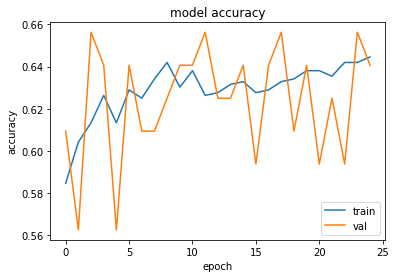

In [0]:
plt.plot(history_ICAE.history['ICAE_classifier_acc'])
plt.plot(history_ICAE.history['val_ICAE_classifier_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='bottom right')
plt.show()

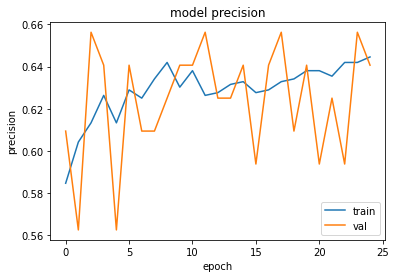

In [0]:
plt.plot(history_ICAE.history['ICAE_classifier_p'])
plt.plot(history_ICAE.history['val_ICAE_classifier_p'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='bottom right')
plt.show()

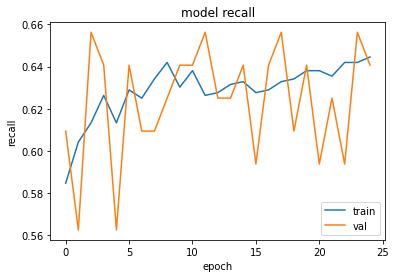

In [0]:
plt.plot(history_ICAE.history['ICAE_classifier_r'])
plt.plot(history_ICAE.history['val_ICAE_classifier_r'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='bottom right')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score

In [0]:
print("acc: ", accuracy_score(labels_to_categorical(test_label), np.round(ae_pred[1])))

acc:  0.6326530612244898


In [0]:
print("AUC", roc_auc_score(labels_to_categorical(test_label), ae_pred[1])) # below 0.5, something is wrong

AUC 0.4717741935483871


In [0]:
labels_to_categorical(test_label)[0]

array([0., 1.], dtype=float32)

In [0]:
# pd.crosstab(labels_to_tocategorical(test_label), ae_pred[0], rownames=['True'], colnames=['Predicted'], margins=True)